In [1]:
import pandas as pd
import numpy as np
from matplotlib.colors import rgb2hex
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import obspy
import matplotlib.patheffects as pe
import matplotlib.ticker as ticker
import time
import calendar
from matplotlib.patches import Rectangle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def ymd_to_ydec(ST):
    y = int(ST.strftime("%Y"))
    dt_starter = dt.datetime(y,1,1,0,0,0)
    diff = (ST.replace(tzinfo=None)-dt_starter)/dt.timedelta(days=1)
    isleapyear = calendar.isleap(y)
    if isleapyear == True:
        diff_dec = diff/366
    else:
        diff_dec = diff/365
    date_dec = y+diff_dec
    return date_dec





def ce_summary_plot(creep_catalogue,instrument_database,region,save_name,palette,creepmeters_ls_list, creepmeters_ls):
    
    region_CMs = instrument_database[instrument_database["Sub_region_map"]==region]
    file_codes = list(region_CMs["File_code"])
    order = list(region_CMs['Creepmeter_abbrv'].drop_duplicates())
    events_region = creep_catalogue[creep_catalogue["sub_region_maps"]==region]

    network = np.unique(events_region["Network"])
    events_region.sort_values(by="Latitude",inplace=True,ascending=False)
    events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
    events_region['Sampling rate'] = events_region['Sampling rate, mins'].astype(str)+' min'

    fig = plt.figure(figsize=(14,10))


    ax1 = plt.subplot(2,3,1)
    ax1.set_xticks([],[])
    ax1.set_yticks([],[])

    
    ax2=plt.subplot(2,3,2)
    creepmeters_ls_list.reset_index(inplace=True,drop=True)
    for i in range(len(creepmeters_ls_list)):
        
        boolarr = np.where(creepmeters_ls['Creepmeter_abbrv']==creepmeters_ls_list[i])[0]

        selected = creepmeters_ls.loc[boolarr]
        sample_freqs = [1,2,5,10,30,60]
        hatchings = ['*','O','||','++','.','XX']
        for j in range(len(selected)):
            duration = selected['diff'].iloc[j].days/365
            fcolour = selected['Colour_maps3'].iloc[j]
            bool_hatch = np.where(sample_freqs==selected['Sampling rate, mins'].iloc[j])[0][0]
            hatch_style = hatchings[bool_hatch]
            y = ymd_to_ydec(selected['Start Time'].iloc[j])
            plt.broken_barh([(y,duration)],(i,0.5),facecolors=fcolour,\
                            edgecolors='black',hatch=hatch_style,zorder=i+1)
            #plt.plot([int(selected['Start Time'].iloc[j].strftime("%Y")),int(selected['Start Time'].iloc[j].strftime("%Y"))],[i,i+0.5])

            
    sampling_freq_all = np.unique(region_CMs['Sampling rate, mins'])
    for k in range(len(sampling_freq_all)):
        bool_hatch = np.where(sample_freqs==sampling_freq_all[k])[0][0]
        hatch_style = hatchings[bool_hatch]
        ax2.add_patch(Rectangle((2024,0.25),0,0, fc ='white',  ec ='black',zorder=-1,hatch=hatch_style,\
                                label='{k} min'.format(k=sampling_freq_all[k])) )
    tick_locations = list(np.linspace(0.25,i+.25,i+1))
    plt.ylim([i+0.5,0])

    plt.yticks(tick_locations,list(creepmeters_ls_list),fontsize=12)
    #plt.plot([2013,2013],[tick_locations[i]-0.25,tick_locations[i]+0.25])

    plt.xticks(fontsize=12,rotation=45)
    
    plt.ylabel('Creepmeter',fontsize=14)
    left,right = ax2.get_xlim()
    plt.xlim(left,right)
    for axis in [ax2.xaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax2.legend(title='Sampling rate')

    ax3=plt.subplot(2,3,3)
    for i in range(len(file_codes)):
        print(file_codes[i])
        for j in range(len(network)):
            try:
                path = "../../../Data/{p}/SAC/{q}.SAC".format(p=network[j],q =file_codes[i])
                st = obspy.read(path)
                tr = st[0]
                tr.interpolate(sampling_rate=tr.stats.sampling_rate)
                tm = tr.times("utcdatetime")
                creep = tr.data
                sample_rate =  round(tr.stats.delta)/60
                tm_dt = []
                for w in range(len(tm)):
                    tm_new = tm[w].datetime
                    tm_dt.append(tm_new)
                file_loc = np.where(instrument_database["File_code"]==file_codes[i])

                #label = instrument_database["Creepmeter_abbrv"].loc[file_loc[0][0]] + ": " + \
                    #str(instrument_database["Sampling rate, mins"].loc[file_loc[0][0]]) + "mins"  
                
                if instrument_database["Sampling rate, mins"].loc[file_loc[0][0]] ==10:
                    foreground='grey'
                else:
                    foreground = 'black'
                ax3.plot(tm_dt,creep,color=instrument_database["Colour_maps3"].loc[file_loc[0][0]],linewidth=1,\
                            path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])

            except FileNotFoundError:
                dummy=10
    
    
    CMs = list(region_CMs['Creepmeter_full_name'].drop_duplicates())
    #print(CMs)
    CM_colours = list(region_CMs['Colour_maps3'].drop_duplicates())
    for k in range(len(creepmeters_ls_list)):
        ax3.plot([],[],color=CM_colours[k],linewidth=1,label = creepmeters_ls_list[k],path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
            
    ax3.set_ylabel("Displacement, mm",fontsize=14)
    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12)
    ax3.legend()


    ax4 = plt.subplot(2,3,4)
    sns.countplot(events_region, x="Creepmeter_abbrv",hue="Sampling rate",palette=palette,order=order)
    ax4.set_xlabel('Creepmeters',fontsize=14)
    ax4.set_ylabel('Number of events',fontsize=14)
    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12)

    ax5 = plt.subplot(2,3,5)
    sns.boxplot(data=events_region, x="Displacement, mm", y="Creepmeter_abbrv",hue="Sampling rate",palette=palette,\
                order=order,flierprops={"marker": "o"})
    ax5.set_ylabel('Creepmeters',fontsize=14)
    ax5.set_xlabel('Displacement, mm',fontsize=14)
    ax5.set_xscale('log')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    ax6 = plt.subplot(2,3,6)
    sns.boxplot(data=events_region, x="Duration, hrs", y="Creepmeter_abbrv",hue="Sampling rate",palette=palette,\
                order=order,flierprops={"marker": "o"})
    ax6.set_xscale('log')
    ax6.set_ylabel('Creepmeters',fontsize=14)
    ax6.set_xlabel('Duration, hrs',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    fig.tight_layout()
    fig.text(0.02,0.97,'a)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 12,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.335,0.97,'b)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 12,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.67,0.97,'c)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 12,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.02,0.50,'d)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 12,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.335,0.50,'e)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 12,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.67,0.50,'f)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 12,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.savefig("../../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.pdf".format(k=save_name))
    fig.savefig("../../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.png".format(k=save_name))
    plt.show()


    return

In [3]:
Creepmeter_dataframe = pd.read_excel('../../../Data/creepmeter_lookup_and_processing_progress.xlsx',index_col=0)
Creepmeter_dataframe.sort_index(inplace=True)
Creepmeter_dataframe.drop([33,40],inplace=True)
Creepmeter_dataframe.reset_index(inplace=True,drop=True)

creepmeters_ls = pd.read_excel('../../../Data/creepmeter_lookup_and_processing_progress.xlsx',index_col=0)
creepmeters_ls['Start Time'] = pd.to_datetime(creepmeters_ls['Start Time'])
creepmeters_ls['End Time'] = pd.to_datetime(creepmeters_ls['End Time'])
creepmeters_ls['diff'] = creepmeters_ls['End Time'] - creepmeters_ls['Start Time']
creepmeters_ls['Creepmeter_abbrv'].iloc[22] = "XSJ2\nXSJ3"
creepmeters_ls['Creepmeter_abbrv'].iloc[21] = "XSJ2\nXSJ3"
creepmeters_ls['Creepmeter_abbrv'].iloc[23] = "XHR1\nXHR2\nXHR3"
creepmeters_ls['Creepmeter_abbrv'].iloc[24] = "XHR1\nXHR2\nXHR3"
creepmeters_ls['Creepmeter_abbrv'].iloc[25] = "XHR1\nXHR2\nXHR3"
creepmeters_ls['Creepmeter_abbrv'].iloc[38] = "XPK1\nXPK2"
creepmeters_ls['Creepmeter_abbrv'].iloc[39] = "XPK1\nXPK2"


creepmeters_ls_list = creepmeters_ls['Creepmeter_abbrv']
creepmeters_ls_list.drop_duplicates(inplace=True)
creepmeters_ls_list.drop([33,40],inplace=True)

creepmeters_ls_list.reset_index(drop=True,inplace=True)

Pakistan = creepmeters_ls_list.iloc[0:1]
Turkey = creepmeters_ls_list.iloc[2:5]
Hayward = creepmeters_ls_list.iloc[5:10]
Hollister = creepmeters_ls_list.iloc[10:17]
Parkfield = creepmeters_ls_list.iloc[17:30]
SoCal = creepmeters_ls_list.iloc[30:]

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/2807376015.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creepmeters_ls['Creepmeter_abbrv'].iloc[22] = "XSJ2\nXSJ3"
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/2807376015.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creepmeters_ls['Creepmeter_abbrv'].iloc[21] = "XSJ2\nXSJ3"
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/2807376015.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [4]:
df_all = pd.read_csv("../../../Data/all_creep_event_picks_new_qc_Jul_03_2024.csv",index_col=0)
file_codes = Creepmeter_dataframe["File_code"]
sub_region = Creepmeter_dataframe["Sub_region_map"]

subregion_events = []
for i in range(len(df_all)):
    alpha = df_all["File_code"].iloc[i]
    beta = np.where(file_codes==alpha)
    subregion_events.append(sub_region[beta[0][0]])
df_all['sub_region_maps'] = subregion_events
df_all.drop(['Longitude','Event_id','ET'],axis=1,inplace=True)

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

xsh_0
xsj2_0
xsj3_0
xhr1_0
xhr2_0
xhr3_0
cwc_0
cwn_0
cwn_1
fxc_0
xmr_0
xmr_1


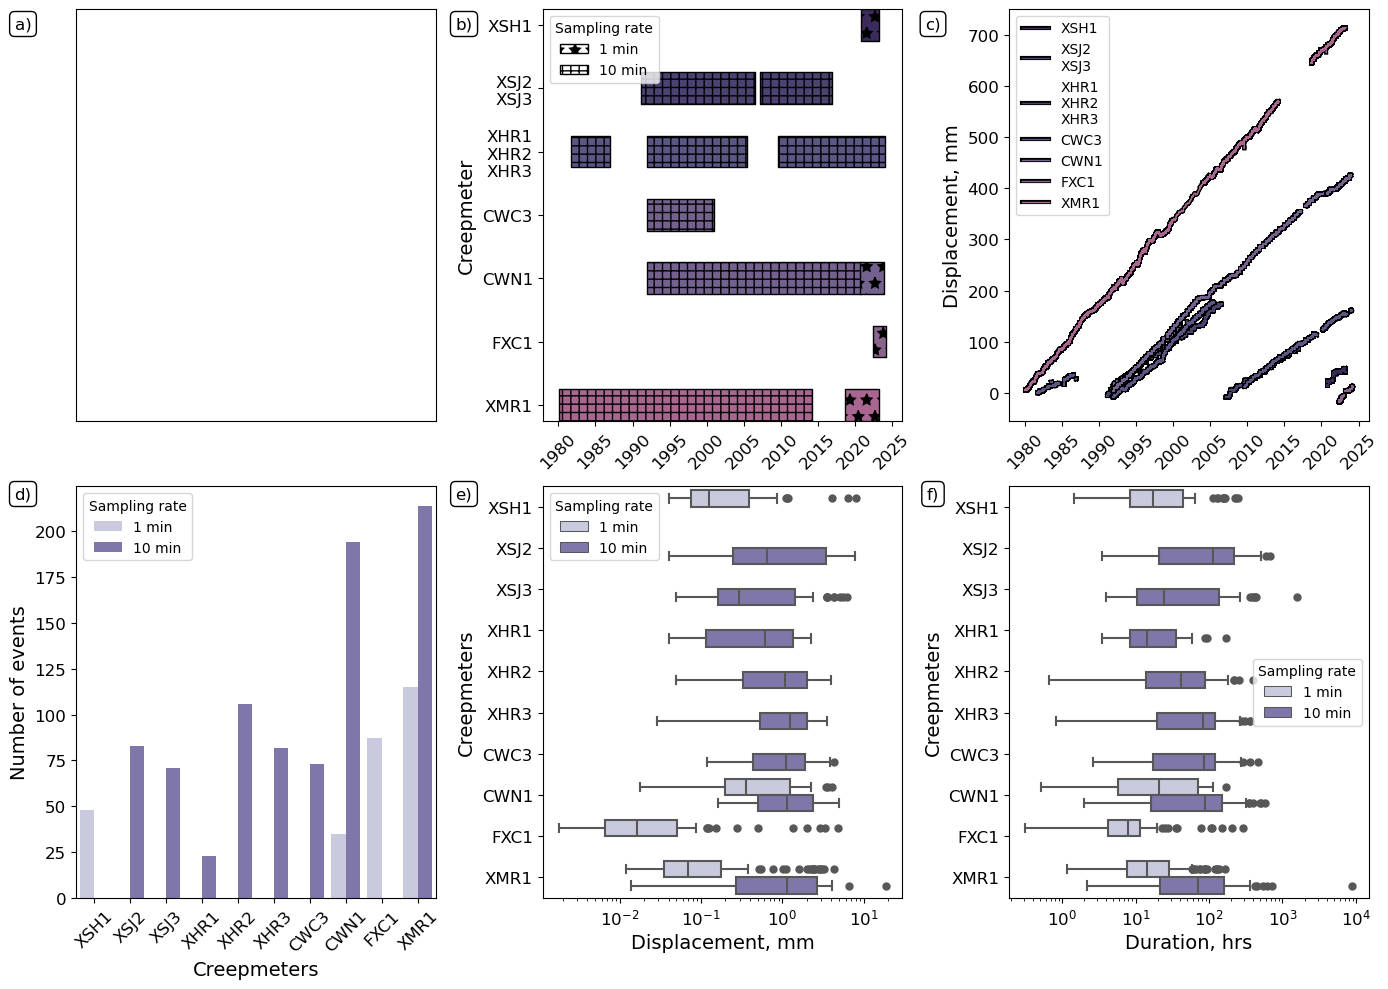

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

xsc_0
xmm_0
xmd_0
xva_0
xrsw_0
xpk1_0
xpk2_0
xta_0
xhsw_0
wkr_0
crr_0
xgh_0
c46_0
x46_0


/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:147: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:160: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig("../../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.pdf".format(k=save_name))
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:161: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig("../../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.png".format(k=save_name))
/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


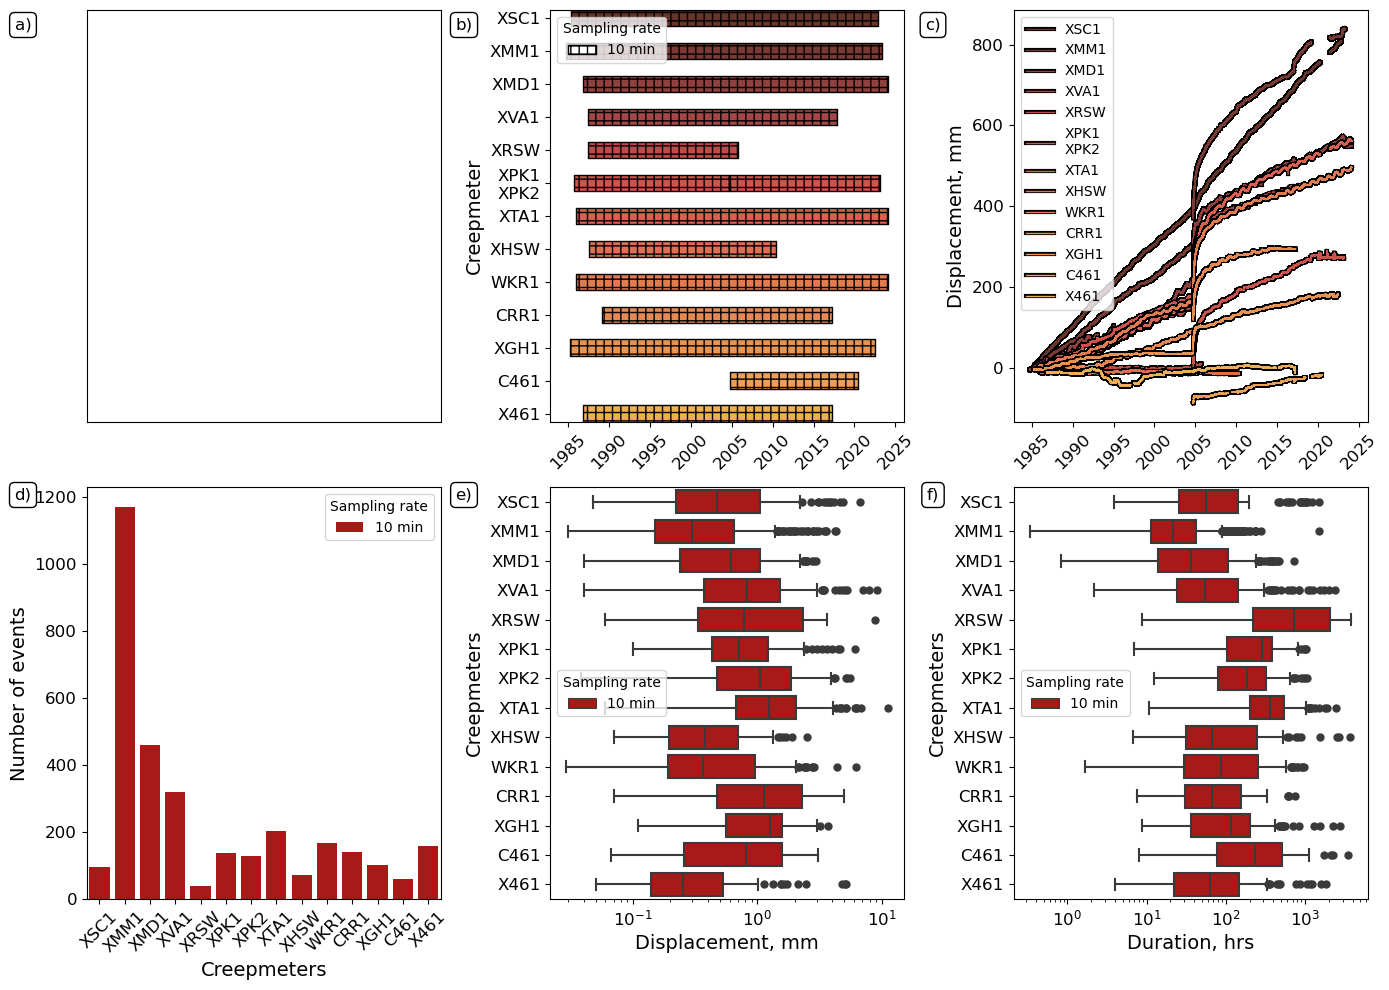

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

cpp_0
cpp_1
ctm_0
ctm_1
ctm_2
coz_0
coz_1
coz_2
chp_0
chp_1
cfw_0
cfw_1
cfw_2


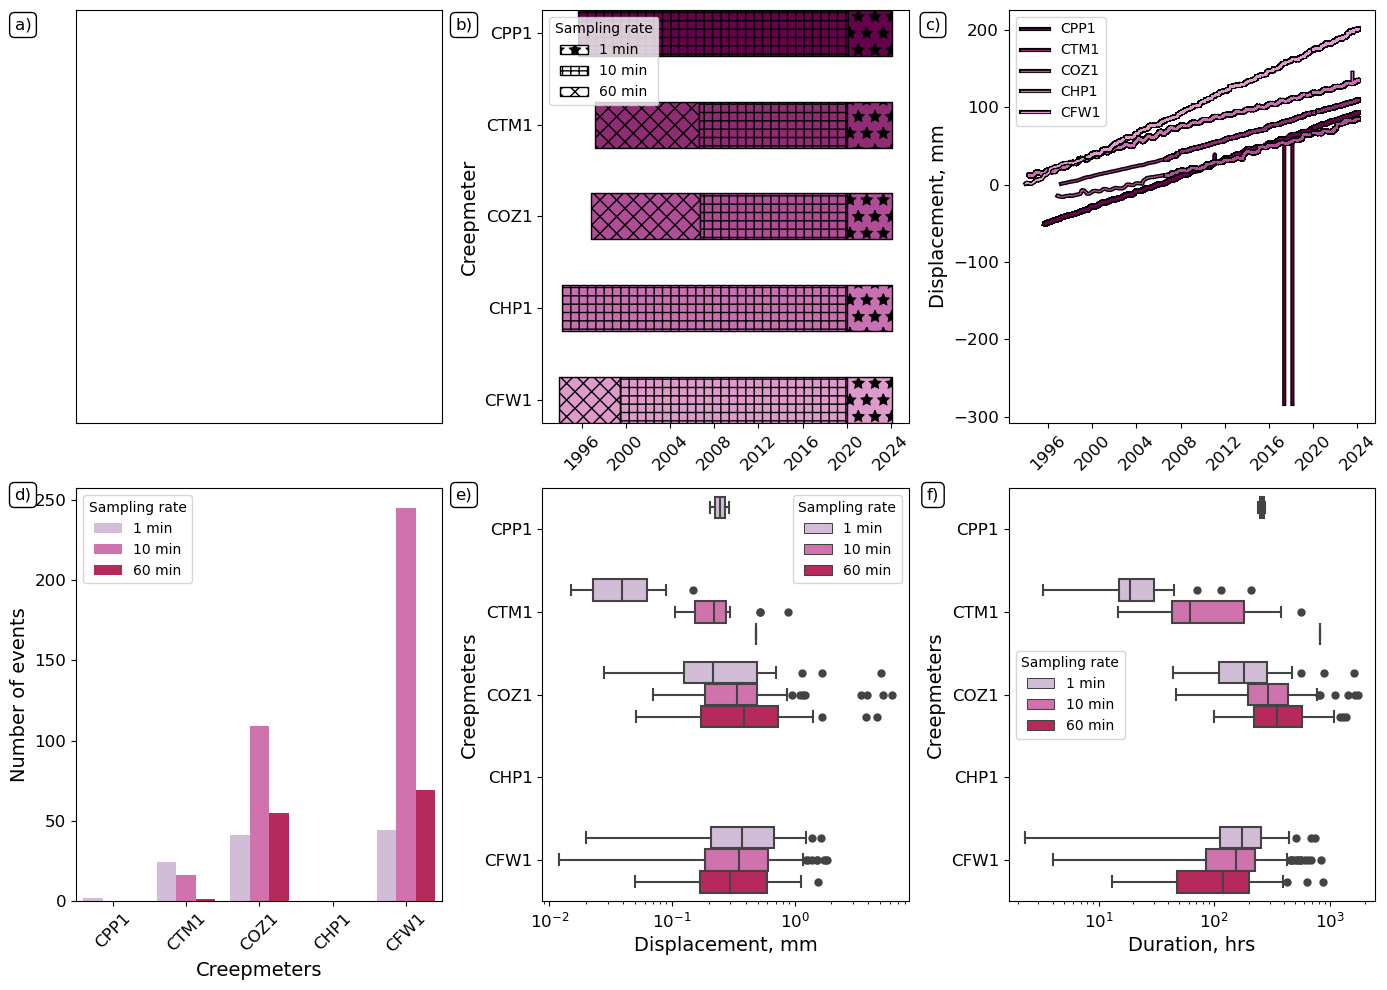

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

dmh_0
dmh_1
dmh_2
sup_0
sup_1
sup_2
rrd_0
rrd_1
rrd_2


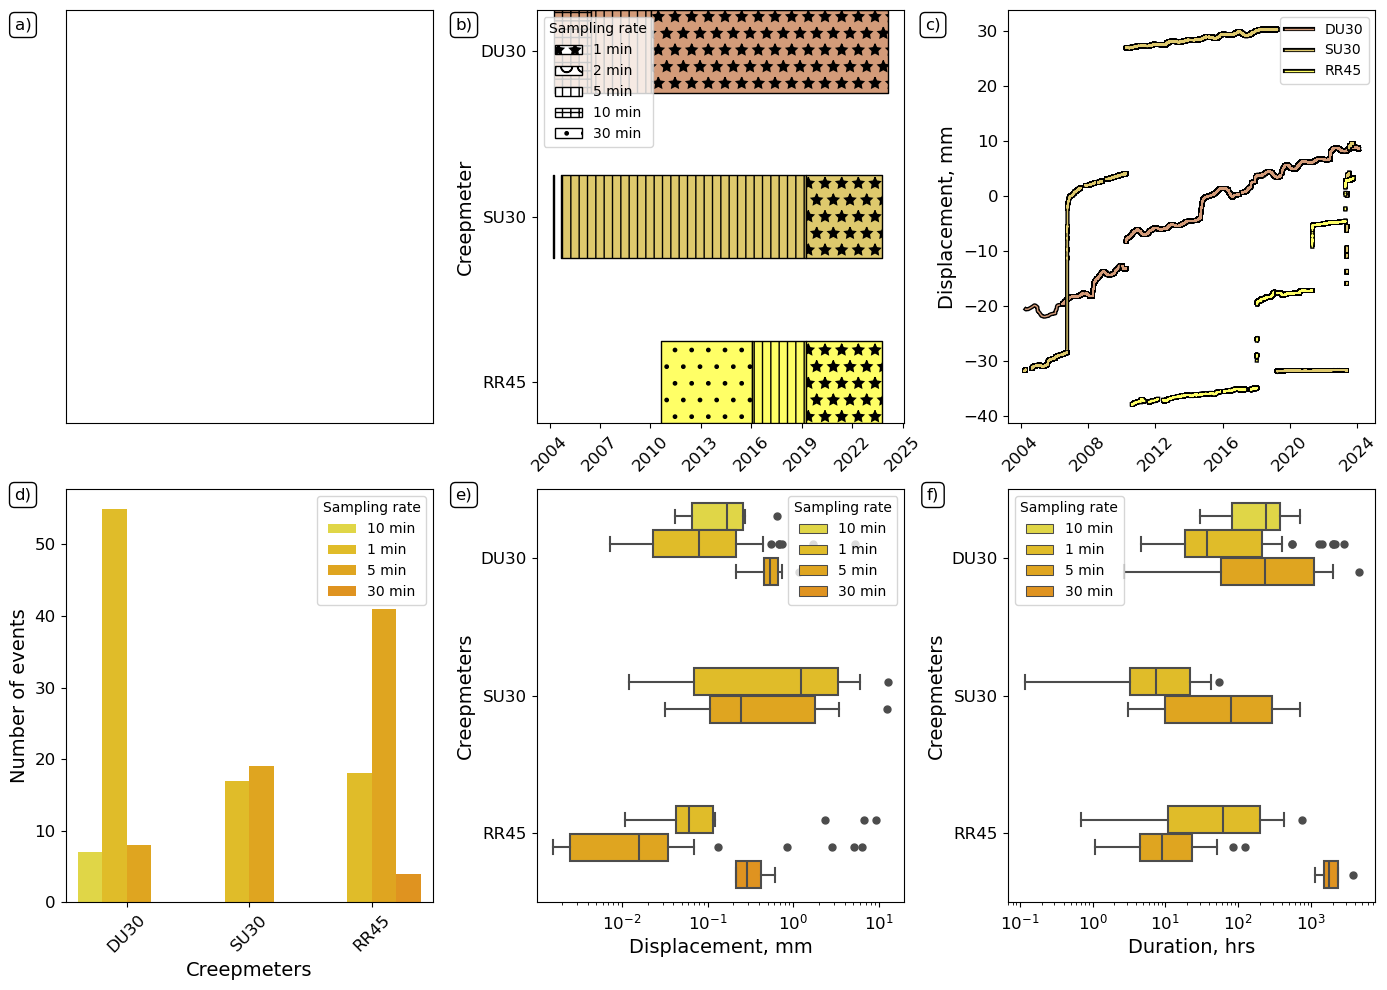

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

inw_0
inw_1
isw_0
wsz_0
wsz_1


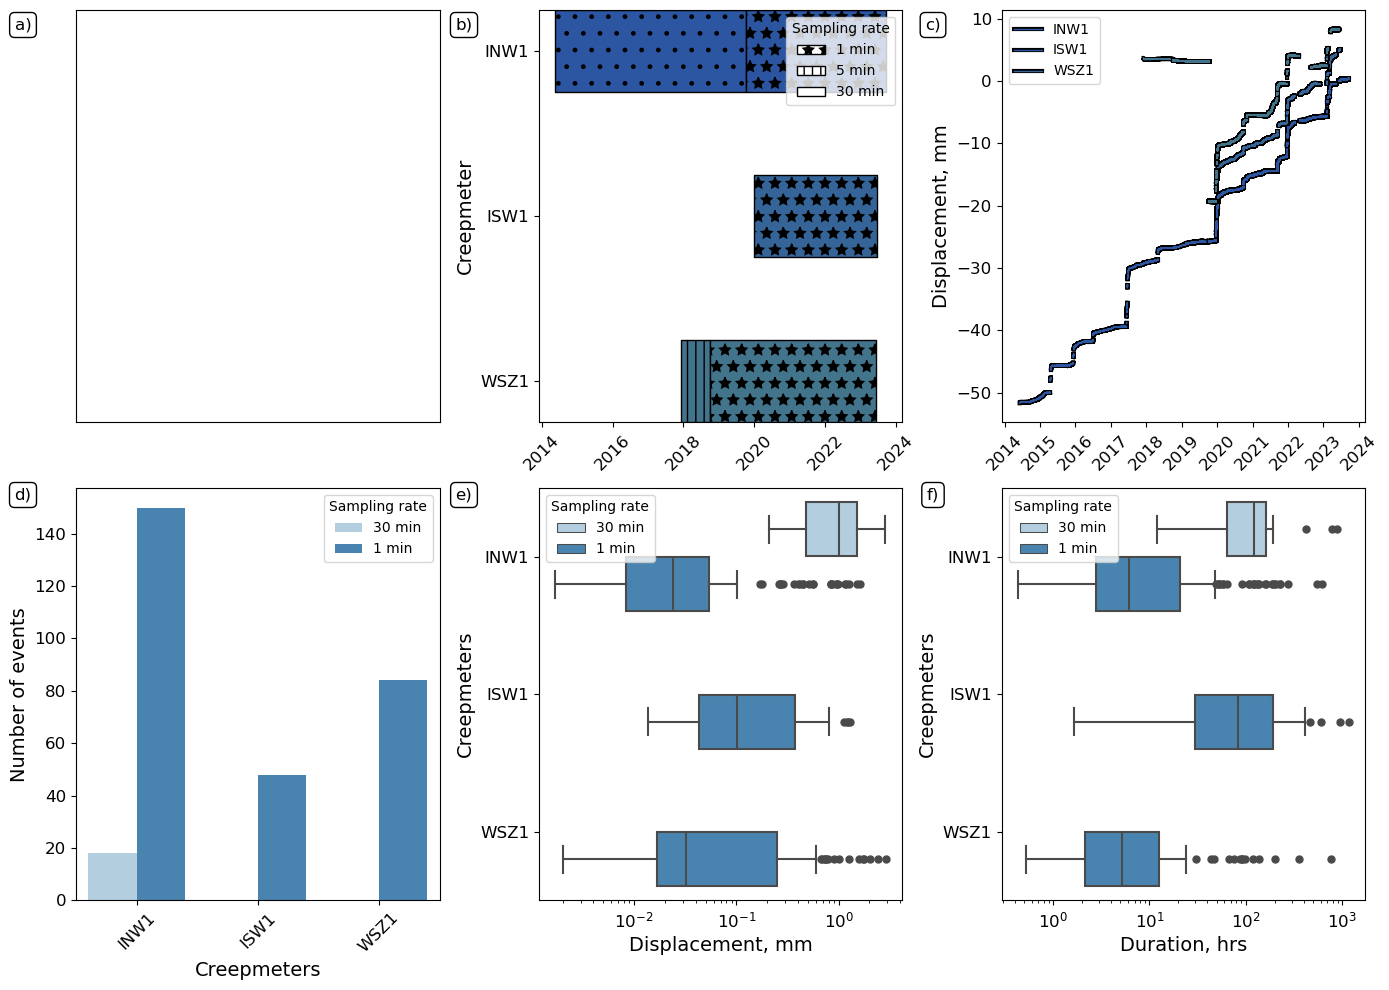

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_77934/3855558444.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

cha_0


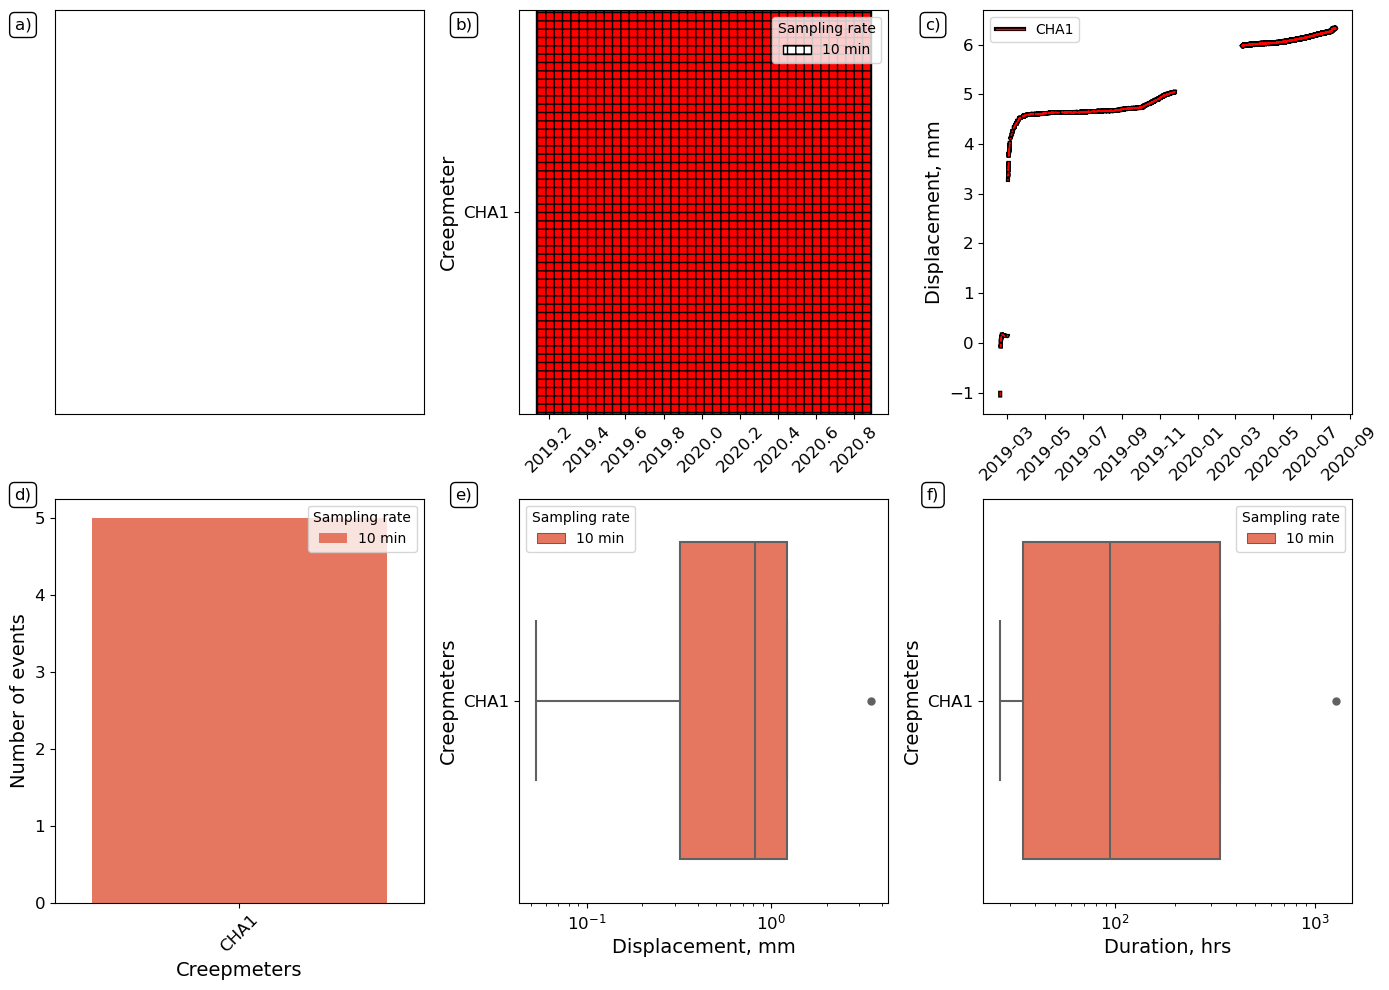

In [5]:
ce_summary_plot(df_all,Creepmeter_dataframe,'Hollister','Hollister','Purples',Hollister,creepmeters_ls)
ce_summary_plot(df_all,Creepmeter_dataframe,'Parkfield','Parkfield','gist_heat',Parkfield,creepmeters_ls)
ce_summary_plot(df_all,Creepmeter_dataframe,'Hayward','Hayward',"PuRd",Hayward,creepmeters_ls)
ce_summary_plot(df_all,Creepmeter_dataframe,'SoCal','SoCal','Wistia',SoCal,creepmeters_ls)
ce_summary_plot(df_all,Creepmeter_dataframe,'North_Anatolian_Fault','NAF','Blues',Turkey,creepmeters_ls)
ce_summary_plot(df_all,Creepmeter_dataframe,'Chaman_Fault','Chaman','Reds',Pakistan,creepmeters_ls)